<a href="https://colab.research.google.com/github/aurimas13/CodeAcademy-AI-Course/blob/main/Projects/Project_1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Imports

In [1]:
"""
A simple walkthrough of how to code a convolutional neural network (CNN)
using the PyTorch library. For demonstration we train it on the very
common MNIST dataset of handwritten digits. In this code we go through
how to create the network as well as initialize a loss function, optimizer,
check accuracy and more.
"""

# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!


# <b>Loading Data

In [2]:
# Load Data

train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# <b> Device



In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# <b> Hyperparameters

In [4]:
# Hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 3e-4 # Karpathy's constant
batch_size = 64
num_epochs = 3

# <b> Neural Network Architecture

In [5]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

# <b> Initialization

In [6]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# <b> Loss & Optimizer

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# <b> Prepare Data

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# <b> Train Neural Network

In [9]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # # Training pass
        # optimizer.zero_grad()

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

        # train_loss += loss.item()

        # train_losses.append(train_loss/len(train_loader))

100%|██████████| 938/938 [00:10<00:00, 92.91it/s] 


# <b> Check metrics & test neural network


In [10]:
# Check accuracy on training & test to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    loss = 0
    # losses = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            loss += criterion(scores, y).item()
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            # losses.append(loss/len(train_loader))  
    model.train()
    accuracy = num_correct / num_samples
    loss_eval = loss / len(loader)
    return accuracy, loss_eval, predictions

print(f"Accuracy on training set: {check_accuracy(train_loader, model)[0]*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)[0]*100:.2f}")
print(f"Loss on training set: {check_accuracy(train_loader, model)[1]:.4f}")
print(f"Loss on test set: {check_accuracy(test_loader, model)[1]:.4f}")

Accuracy on training set: 96.07
Accuracy on test set: 96.37
Loss on training set: 0.1294
Loss on test set: 0.1160


# <b> Prediction (Visual or Written)

In [11]:
import numpy as np
from matplotlib import pyplot as plt

# Choosing a number index from data to predict
img = data[17]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)
print(data.shape)

# Sice we want to use already pretrained wieghts to make some predicition
# we are turing off gradients
with torch.no_grad():
  logits = model.forward(img)

torch.Size([1, 1, 28, 28])
torch.Size([32, 1, 28, 28])


[6.4382668e-08 2.5005881e-03 9.9718362e-01 2.5700647e-04 6.4747394e-09
 6.0207435e-07 1.4314628e-07 4.6282374e-05 1.1717482e-05 7.6848528e-09] 

The predicted label is : 2



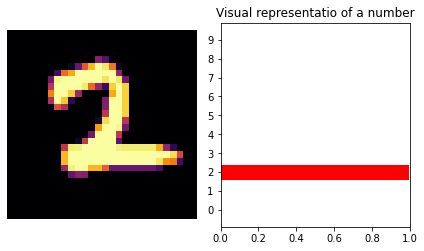

In [12]:
# We will tak softmax for probabilities
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities,'\n')

# Visual representation of a predicted number
fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_xlim(0, 1)
ax2.set_title('Visual representatio of a number')

plt.tight_layout()

# Written representation of a predicted number
y_pred = model(img.to(device))
_, predicted = torch.max(y_pred.data, -1)
print(f'The predicted label is : {predicted.item()}\n')